#### Basic Temporal Information.

This demo shows how to perform basic temporal information analysis. 
Parts are as follows:
1. Peakfind and Event Counter
2. Basic peak information
3. Waittime distribution analysis (random disp and burstiness)
4. FFT spectrum analysis
5. Wavelet spectrum analysis
___

- Load and import 

In [1]:
#%%
import Common_Functions as cf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tqdm import tqdm
import pandas as pd
from Brain_Atlas.Atlas_Mask import Mask_Generator
import seaborn as sns
  
wp = r'D:\ZR\_Data_Temp\Ois200_Data\Full_Demo\Wild_Type\Preprocessed'
MG = Mask_Generator(bin=4)

series = np.load(cf.join(wp,'z_series.npy'))
# join chamber mask with brain area mask, getting only mask with values.
mask = cv2.imread(cf.join(wp,'Chamber_mask.png'),0)>0
joint_mask = (series.std(0)>0)*mask
# mask and clip input graph.
# NOTE this part is important for getting correct results.
series = np.clip(series,-3,3)*joint_mask

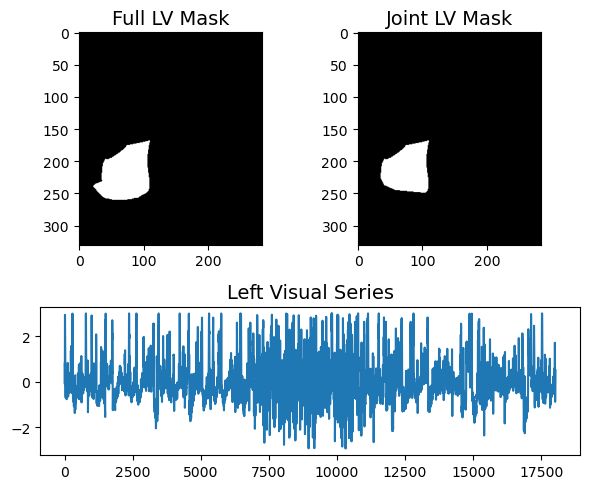

In [2]:
# We use Left visual area as example. 
# MG class now contains a new function that you can get whole functional mask directly. All sub-domians will be combined together.
LV_Mask_full = MG.Get_Func_Mask('VI','L')
LV_Mask_joint = joint_mask*LV_Mask_full # ignore area outside of chamber.


# plot part below. it also demos how to plot unevenly cutted fig.
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(6,5))
gs = gridspec.GridSpec(2, 2, height_ratios=[1,0.7])  # 1 row height for ax1 and ax2, 2 for ax3
# fig,ax = plt.subplots(ncols=2,nrows=2,figsize = (6,3),dpi = 300)
ax1 = fig.add_subplot(gs[0, 0])  # First row, first column
ax2 = fig.add_subplot(gs[0, 1])  # First row, second column
ax3 = fig.add_subplot(gs[1, :])   # Second row, spanning both columns
ax1.imshow(LV_Mask_full,cmap='gray')
ax2.imshow(LV_Mask_joint,cmap='gray')
ax1.set_title('Full LV Mask',size = 14)
ax2.set_title('Joint LV Mask',size = 14)

# average only pixels in joint left visual mask.
LV_curve = series[:,LV_Mask_joint].mean(1)
ax3.plot(LV_curve)
ax3.set_title('Left Visual Series',size = 14)
fig.tight_layout()

___
##### Part1, Peak find.    
- This is very easy through scipy package.    
Docs here: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html    
Code below only show how to use it.    


properties include: ['peak_heights', 'prominences', 'left_bases', 'right_bases']


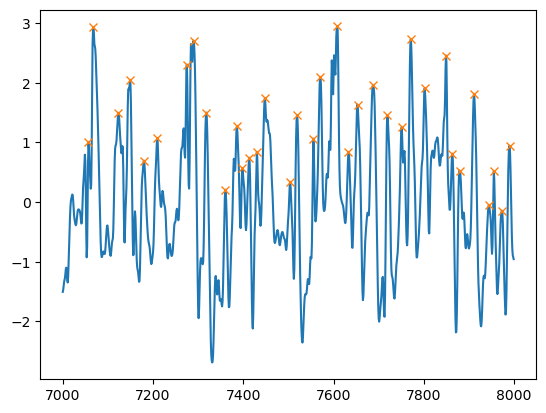

In [3]:
from scipy.signal import find_peaks,peak_widths

x = LV_curve
peaks, properties = find_peaks(x, prominence=0.75,distance=10,height=-0.5) 
# prominence: peak must be how higher than local max. 
# distance: dist of 2 peak(avoid noise).
# height: min height of peak.

# peaks is the location of all peaks. use x[peaks] can find all peak's height.
# properties is a dict contains info of all peaks.
print(f'properties include: {list(properties)}')


# below shows a example of cutted series.
start = 7000
end = 8000
plt.plot(range(start,end),x[start:end])
peaks_cut = list(filter(lambda x: start < x < end, peaks)) # select peaks in range.
plt.plot(peaks_cut,x[peaks_cut], "x")
plt.show()




- And you can calculate event frequency easily.

In [4]:
fps = 5
event_num = len(peaks)
time = len(series)/fps
event_freq = event_num/time
print(f'Total {event_num} peaks find, having a Frequency {event_freq:.4f} Hz')


Total 398 peaks find, having a Frequency 0.1104 Hz


___
##### Part 2, Basic peak information.
- Below shows basic information of peaks. Including:
1. FWHM (peak width)
2. relationship between peak width and height prominence

Get half peak length using scipy's peak_width function.

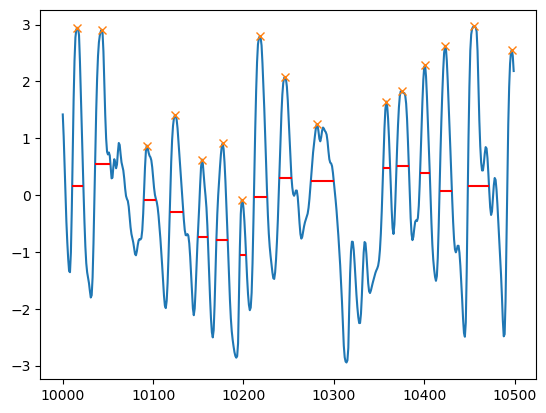

In [5]:
# function below shows the width of each peak, after it decay to half height.
results_half = peak_widths(x, peaks, rel_height=0.5)
# results_half in shape (width,FWHM,left boulders,right boulders)

start = 10000
end = 10500


plt.plot(range(start,end),x[start:end]) # plot curve
peaks_cut = list(filter(lambda x: start < x < end, peaks)) # get peak in range
results_half_cut = tuple(map(lambda lst: lst[(results_half[2]>start)*(results_half[3]<end)], results_half)) # get part peak in range
plt.plot(peaks_cut, x[peaks_cut], "x") # plot peak in range
plt.hlines(*results_half_cut[1:], color="r",linestyles='-') # plot FWHM

- And what's the relationship between peak height and peak length?    
We expect a linear correlation for very easy logic.    

Here we show that peak height only correlates with prominences, but irrevelant to it's absolute height.

Text(43, 2, 'r=-0.027; p=0.586')

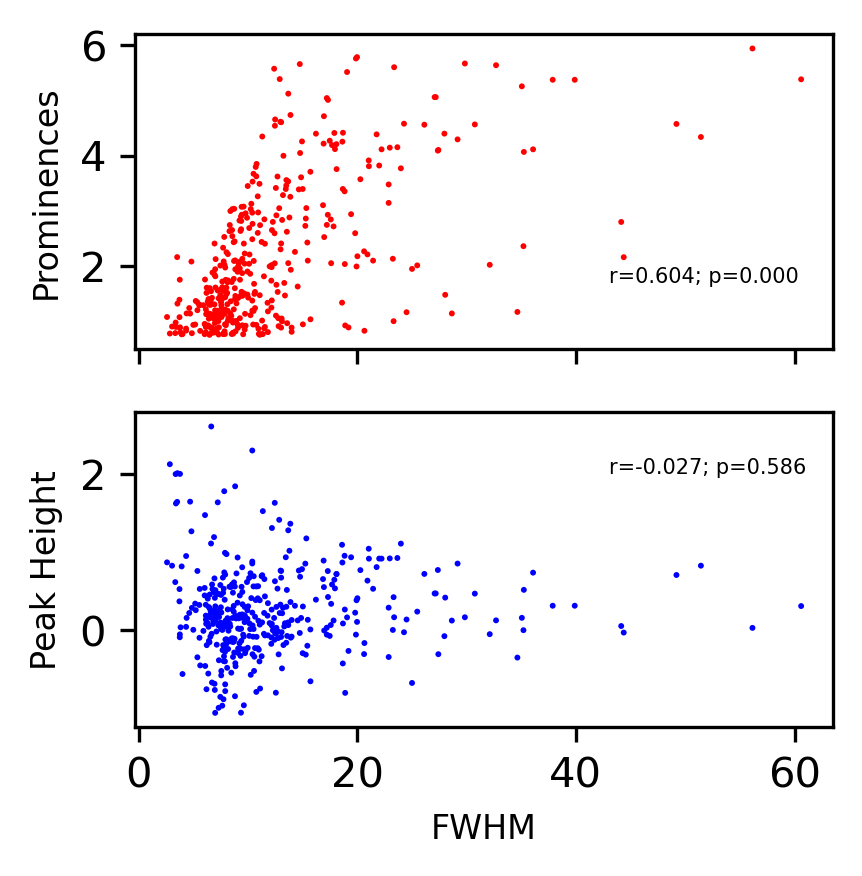

In [6]:
from scipy.stats import pearsonr

fig,ax = plt.subplots(ncols=1,nrows=2,figsize = (3,3),dpi = 300,sharex=True)

# plot correlation between peak widths and peak's  heights.
ax[0].scatter(x = results_half[0],y = properties["prominences"],s = 2,c='r',edgecolor ='none')
ax[1].scatter(x = results_half[0],y = results_half[1],s = 2,c ='b',edgecolor ='none')

ax[0].set_ylabel('Prominences',size = 8)
ax[1].set_ylabel('Peak Height',size = 8)
ax[1].set_xlabel('FWHM',size = 8)

# calculate pearson r and annotate it on graph.
r_prom,p_prom = pearsonr(results_half[0],properties["prominences"])
r_peak,p_peak = pearsonr(results_half[0],peaks)
ax[0].annotate(f'r={r_prom:.3f}; p={p_prom:.3f}',(43,1.7), fontsize=5)
ax[1].annotate(f'r={r_peak:.3f}; p={p_peak:.3f}',(43,2), fontsize=5)


___
##### Part 3, waittime analysis.    
- Besides peak and width, intervals between events are important too.    

If interval conforms to some distribution, event might be a random distribution.

In [7]:
# first we need to calculate intervals between all peaks.

def calculate_waiting_times(event_times):
    # Sort the event times chronologically
    sorted_times = sorted(event_times)
    
    # Calculate the waiting time between consecutive events
    waiting_times = []
    for i in range(len(sorted_times) - 1):
        waiting_time = sorted_times[i+1] - sorted_times[i]
        waiting_times.append(waiting_time)
    return waiting_times

intervals = calculate_waiting_times(peaks)

- Burstiness calculation is possible for a event series.    
Check https://link.springer.com/chapter/10.1007/978-3-642-36461-7_3 for details.    
- Define B = (sig-mu)/(sig+mu), while sig and mu are std and mean of waittime duration.  
B = 0 indicate a total random process, follow the possion distribution.    
B > 0 means bursty signal, more bursty than posion, B = 1 as total bursty signal.    
B < 0 means more regular signal, indicating more regular signal, B = -1 as periodic signal    

In [14]:
B = (np.std(intervals)-np.mean(intervals))/(np.std(intervals)+np.mean(intervals))
print(f'Current location have Burst index B = {B:.4f}')

Current location have Burst index B = -0.0548


As we can see above, for OI signal, the fluctuation is almost fully possion.

In [8]:
# first thought will test whether waittime conforms to Exponential distribution.

from scipy.stats import expon
params = expon.fit(intervals) # params in shape (loc,scale), you can check expon distribution by yourself.
print(f'Fitted Exponential Distribution at Location {params[0]:.3f}, Scale ={params[1]:.3f}')

Fitted Exponential Distribution at Location 10.000, Scale =35.325


- Codes after will show the fitted curve and raw distribution.

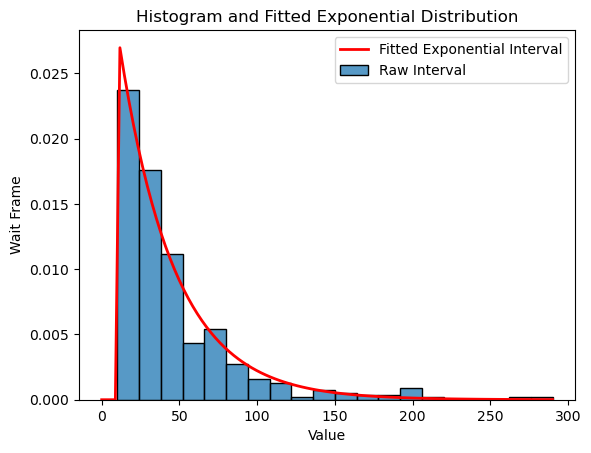

In [9]:
x = np.linspace(0, max(intervals), 100)
pdf_fitted = expon.pdf(x, *params) # probability distribution function,pdf

# Plot the fitted exponential distribution
plt.plot(x, pdf_fitted, 'r-', label='Fitted Exponential Interval', lw=2)
sns.histplot(intervals,stat='density',bins=20,label='Raw Interval')
plt.title('Histogram and Fitted Exponential Distribution')
plt.xlabel('Value')
plt.ylabel('Wait Frame')
plt.legend()
# plt.grid()
plt.show()

- Is the fit good enough? Can we Quantitative answer it?    

Yes we can. Use Q-Q plot can we show the quality of fit.

- The easy way:

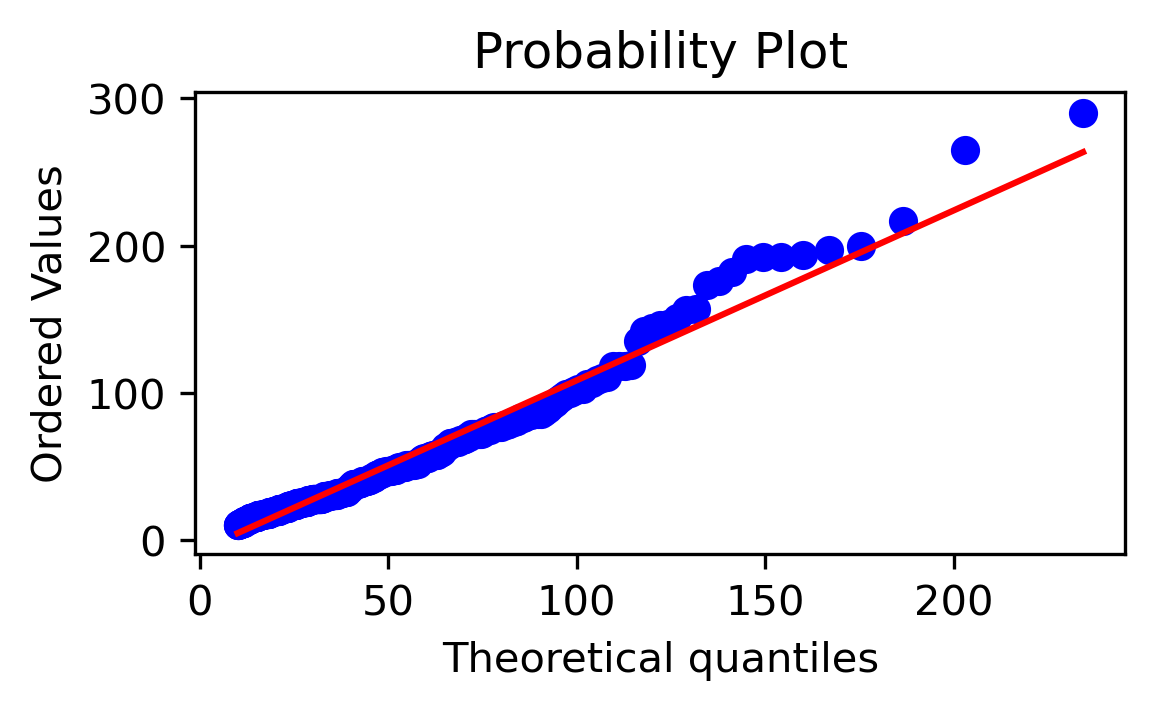

In [10]:
from scipy.stats import expon, probplot, linregress

fig, ax = plt.subplots(figsize=(4,2),dpi = 300)
res = probplot(intervals, dist="expon", sparams=params, plot=ax)

- The Graduate Students' Way:

(0.0, 300.0)

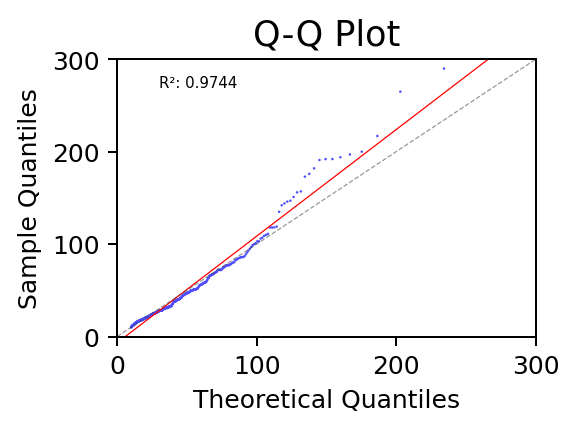

In [11]:
# we don't use in-build plot tools, as it's ugly and hard to finetune.
res =probplot(intervals, dist="expon", sparams=params)

theoretical_quantiles = res[0][0]           # Theoretical quantiles
sample_quantiles = res[0][1]    # Sample quantiles
slope, intercept, r_value, p_value, std_err = linregress(theoretical_quantiles, sample_quantiles)                           # linear fit of QQ Plot.
r_squared = r_value**2                      # r2 of fit.


### then plot it here.
fig, ax = plt.subplots(figsize=(3,2),dpi = 180)
# plot scatter
ax.scatter(x = theoretical_quantiles,y= sample_quantiles,edgecolors='none',s=1,color=[0.3,0.3,1]) 
# plot fitted line
x = np.linspace(0, 300,10)
y = slope * x + intercept
ax.plot(x, y,color = 'red',lw=0.5) # plot fitted line
ax.plot(x,x,lw=0.5,linestyle='--',color = [0.2,0.2,0.2],alpha = 0.5) # plot diagonal
ax.text(0.1, 0.9, f'R²: {r_squared:.4f}', transform=ax.transAxes, fontsize=6, color='black')

ax.set_title('Q-Q Plot',size = 14)
ax.set_xlabel('Theoretical Quantiles',size = 10)
ax.set_ylabel('Sample Quantiles',size = 10)
ax.set_ylim(0,300)
ax.set_xlim(0,300)



- Burstiness Analysis.    
ref here:https://doi.org/10.1007/978-3-642-36461-7_3    

If you have a interval info, you can estimate the burstiness of event distribution. Define burstiness index B = (std(t)-mean(t))/(std(t)+mean(t)), t is the interval of events.    

B = -1 means fully periodic signal    
B = 0 as posion signal (full-random process)    
B =1 as highest burstness(actually 1 is impossible, but higher B means higher burstiness)

___
##### Part 4, FFT Spectrum.    
This will show the power of each frequency band.    
Function is already packed, demo below will show it's usage.
- Note that first value of spectrum include DC power, so it can be **REALLY** high if the signal's mean != 0

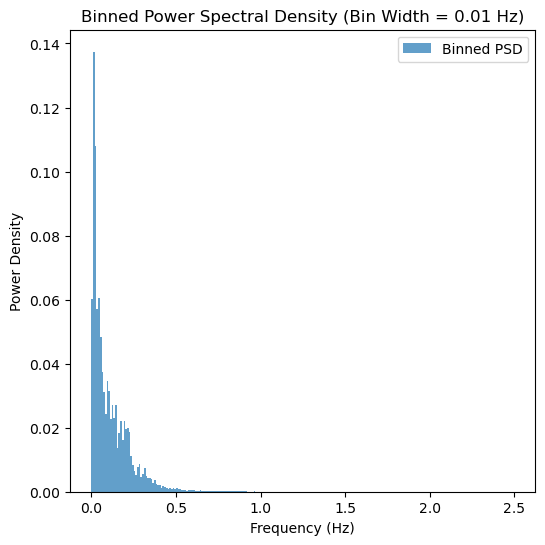

Raw tick have 9012 ticks, binned into 250 ticks.


In [12]:
from Signal_Functions.Spectrum_Tools import *

freq,power,freq_raw,power_raw,total_power = FFT_Spectrum(series=LV_curve,fps=5,ticks=0.01,plot=True)
print(f'Raw tick have {len(freq_raw)} ticks, binned into {len(freq)} ticks.')

##### Params:
# series: input signal series.
# fps: capture frequency
# ticks: Output tick. 0.01 means output frequency is in 0.01 Hz scale.
# plot: Whether show histogram directly. Default is False.
###### Output:
# freq: binned frequency of each band
# power: power density at each freq bin.
# freq_raw : raw tick of frequency. Length of it is affected by series length. Not recommende.
# power_raw : raw power density at each freq_raw. Length variable.
# total_power : Whole power of current sigal.


- Slide-window power spectrum will show variation of power band.

 57%|█████▋    | 32/56 [00:00<00:00, 319.92it/s]

100%|██████████| 56/56 [00:00<00:00, 325.66it/s]


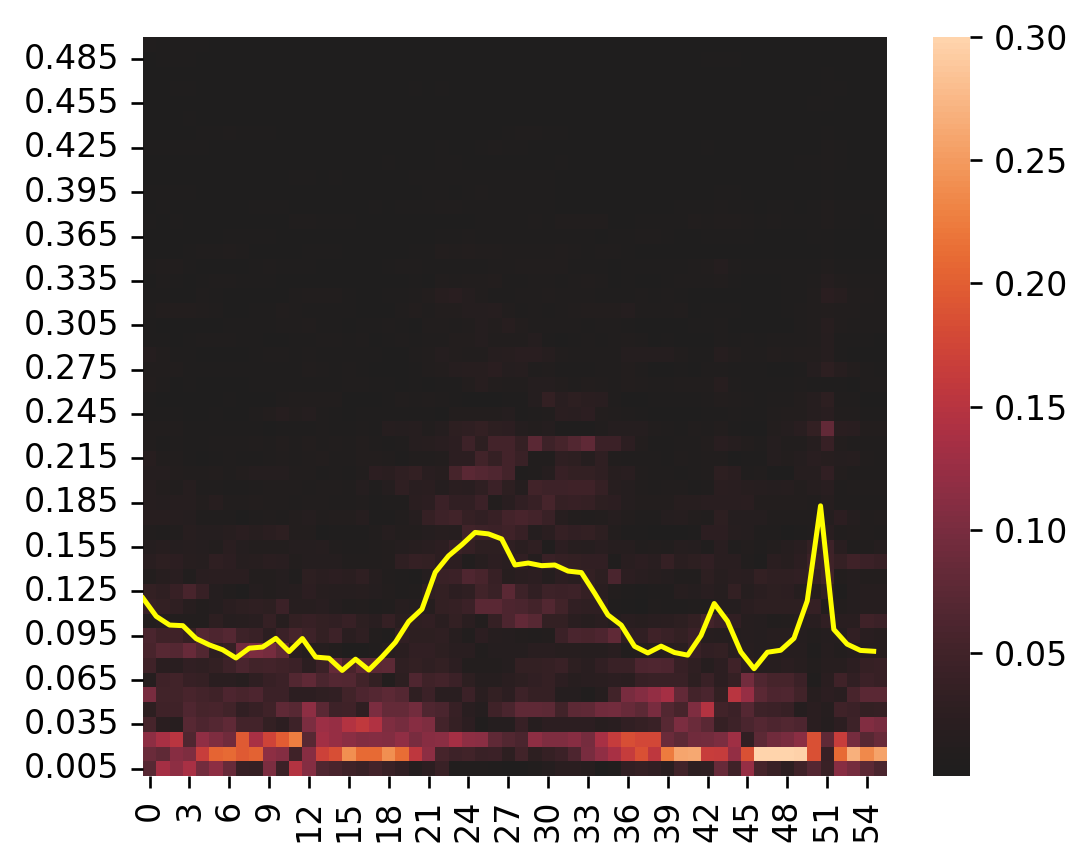

In [13]:
# the function is already be packed too.
fps = 5
win_size = 300*fps
win_step = 60*fps
ticks = 0.01

slide_spectrum = FFT_Spectrum_Slide(series=LV_curve,win_size=1500,win_step=300,fps=5,ticks=ticks,normalize=True) # normalize = True will show power density, otherwise raw power will be shown.


# calculate weighted average frequency of each time window.
avr_freq = np.zeros(shape = slide_spectrum.shape[1])
for col in slide_spectrum.columns:
    total_power_density = slide_spectrum[col].sum()
    weighted_sum = (slide_spectrum.index * slide_spectrum[col]).sum()
    avr_freq[col] = weighted_sum / total_power_density


# plot here
fig,ax = plt.subplots(figsize = (5,4),dpi = 240)
# plot only power below 0.5Hz
ax.plot(range(len(avr_freq)),avr_freq/ticks,color = 'yellow')
sns.heatmap(slide_spectrum.loc[:0.5,:],center = 0,vmax=0.3,ax =ax)
ax.invert_yaxis() 


As you can see above, visual response seems to have higher frequency at 20-35 min. You can compare behavior data for reason and evidence.

___
##### Part 5, Wavelet analysis.
- Wavelet is an advanced spectrum analysis technique, it works just like FFT, but with variable freq ticks.    

Better but slower, and it will also not show a full power.

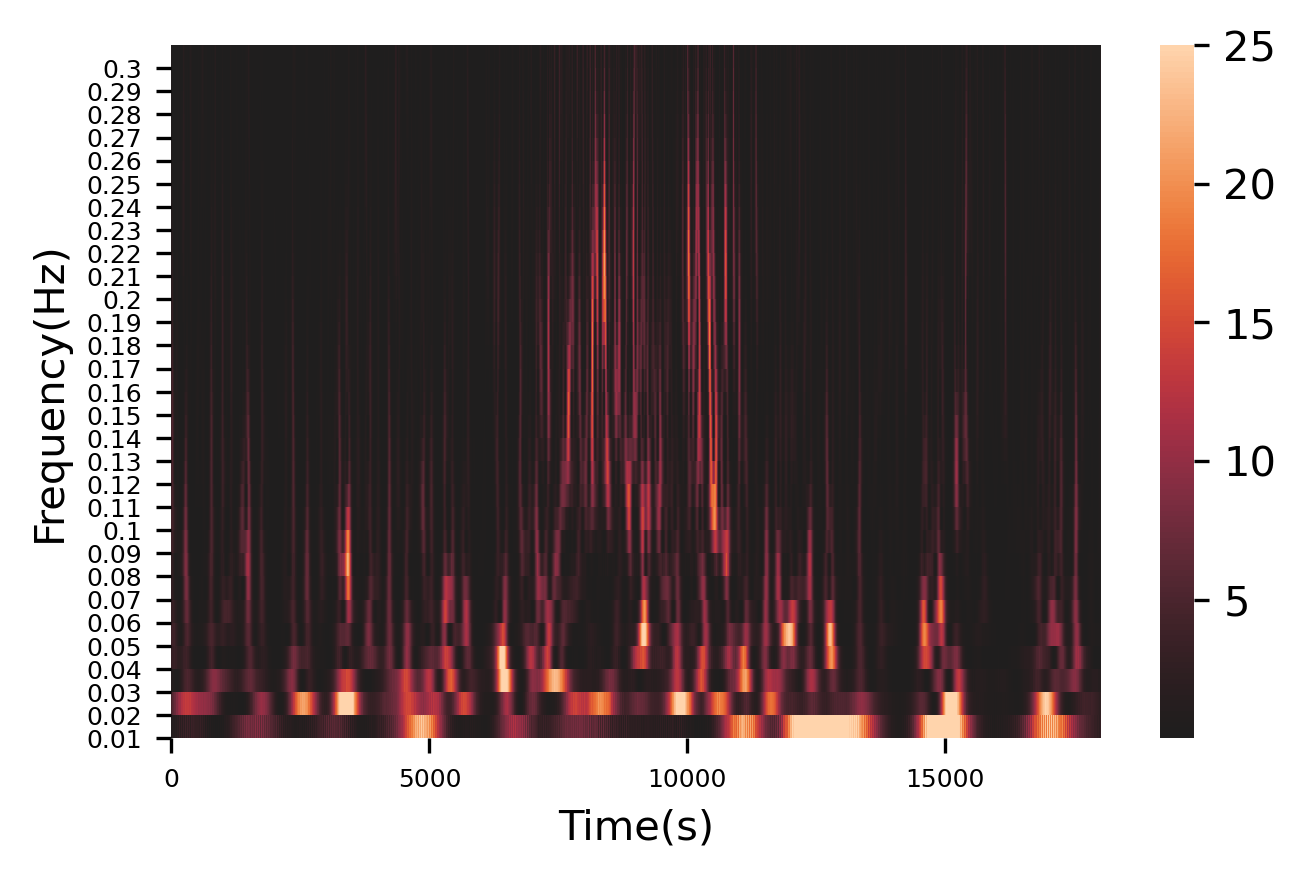

In [14]:
# get wavelet coherent on given freq band.
freqs = np.linspace(0.01,0.3,30).round(3)
wavelets = Wavelet_Coherent(signal = LV_curve,fps=5,freqs = freqs)

# plot part
fig,ax = plt.subplots(figsize= (5,3),dpi=300)
sns.heatmap(wavelets,center=0,xticklabels=False,yticklabels=False,ax = ax,vmax = 25)
ax.set_yticks(range(len(freqs)))
ax.set_yticklabels(freqs,size = 6)
ax.set_xticks([0,5000,10000,15000])
ax.set_xticklabels([0,5000,10000,15000],size = 6)
ax.set_ylabel('Frequency(Hz)')
ax.set_xlabel('Time(s)')
ax.invert_yaxis() 


- As you can see, wavelet is a little different from FFT, as by default, wavelet will return log-like power spectrum.    

Default wavelet will show below.

[Text(0, 0, '0'),
 Text(5000, 0, '5000'),
 Text(10000, 0, '10000'),
 Text(15000, 0, '15000')]

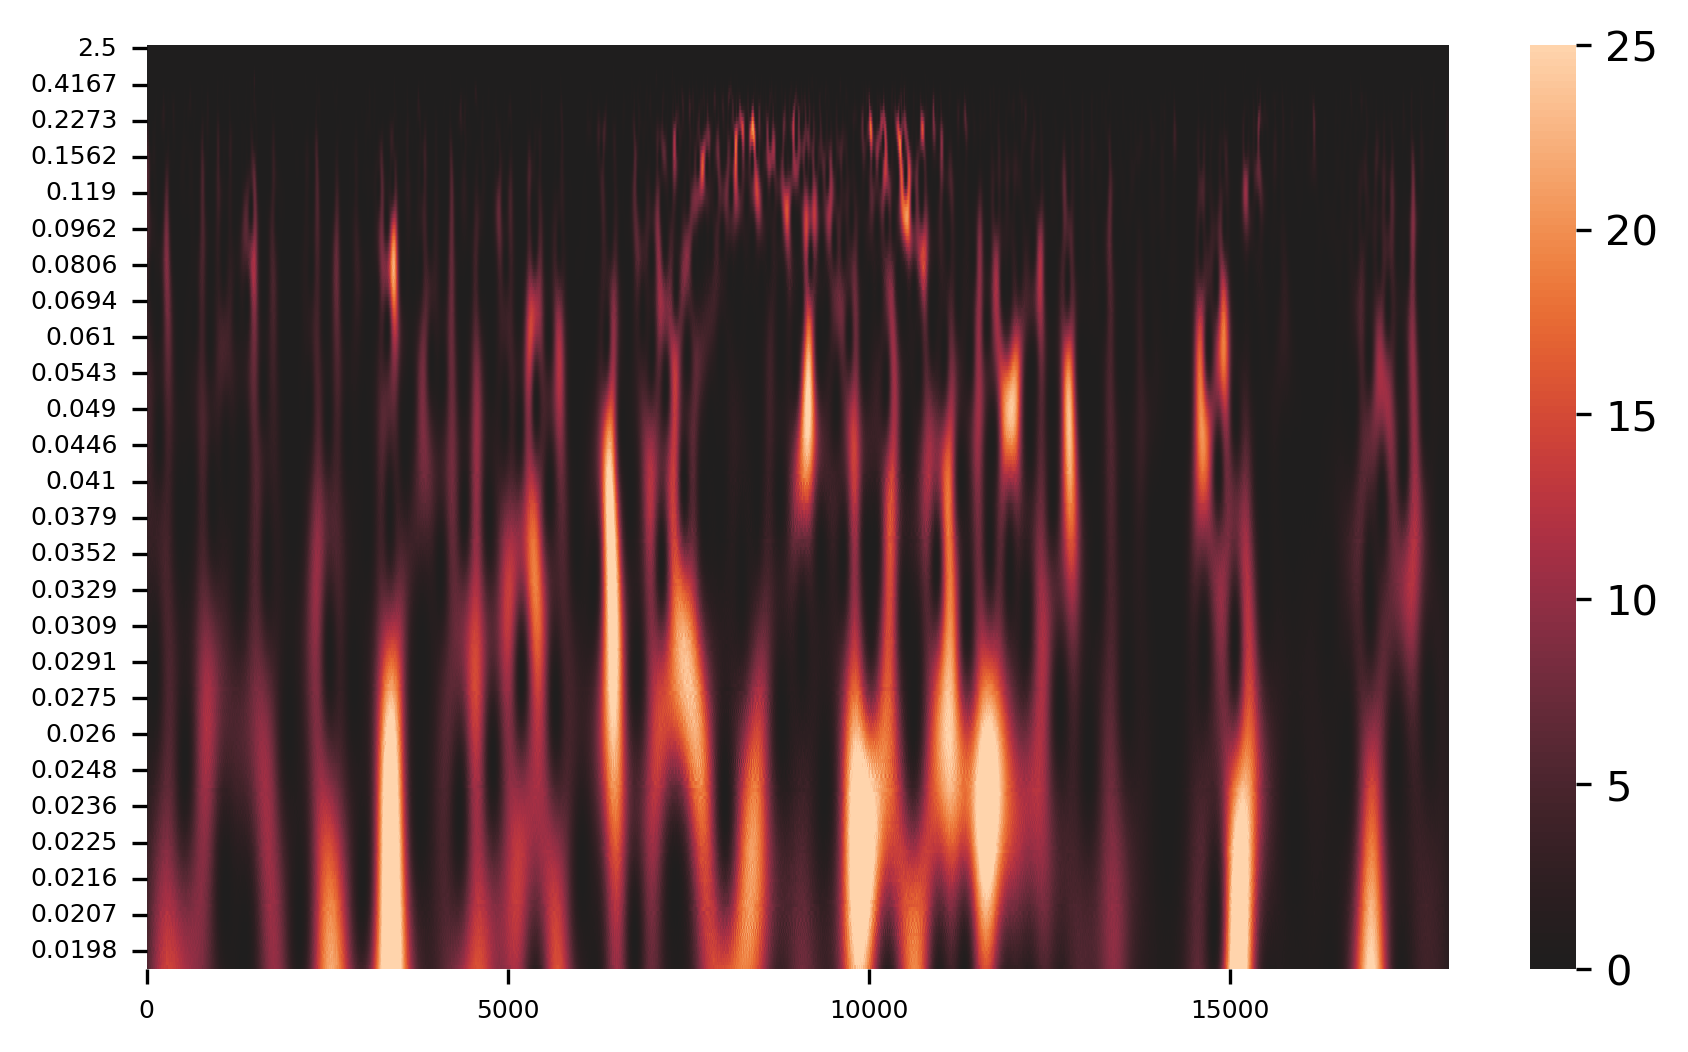

In [15]:
wavelet_num = 256
scales = np.arange(1,wavelet_num+1)
fps = 5

coefficients, frequencies = pywt.cwt(LV_curve, scales, "cmor1.5-1.0", sampling_period=1/fps)
coherence = pd.DataFrame(np.abs(coefficients)**2, index=frequencies, columns=range(len(LV_curve)))

# plot example
fig,ax = plt.subplots(figsize= (7,4),dpi=300)
sns.heatmap(coherence,center=0,xticklabels=False,ax = ax,vmax = 25)

ytick_id = range(1, len(frequencies), 10)
ax.set_yticks(ytick_id)
ax.set_yticklabels(frequencies.round(4)[ytick_id],size = 6)
ax.set_xticks([0,5000,10000,15000])
ax.set_xticklabels([0,5000,10000,15000],size = 6)
# ax.invert_yaxis() 


As you can see, wavelet works default on log-scale frequency.    
This method are more sensitive to dynamics, works like a very-thin window FFT.